## Introduction to trust region samping

In this notebook we briefly explain our trust region samplig.

Lets start with quoting [wikipedia](https://en.wikipedia.org/wiki/Trust_region)

> In mathematical optimization, a trust region is the subset of the region of the
> objective function that is approximated using a model function (often a quadratic).

A trust region is thus a space over which the criterion (objective) function is evaluated to build an approximation model. Using the information from the approximation model and the true evaluations, trust region optimizers decide on how to move (or shrink/expand) the trust region, until the optimizer convergences. There is a clear trade-off between building an accurate approximation model (evaluate many points inside the region) and runtime. To mitigate this problem we use two main ideas. First, we fill the region with evaluation points such that certain criteria are fulfilled / optimized. This results in (optimal) [Latin Hypercube samples](https://en.wikipedia.org/wiki/Latin_hypercube_sampling). Using these points can increase the accuracy of the approximation model compared to naively using random samples inside the region. And second, we recycle previous evaluation to reduce runtime. Below we go through a visual example. Before we will explain what an optimal Latin Hypercube is.


### Latin Hypercube

A Latin Hypercube sample is a sample from a multivariate distribution that fulfills certain properties. Most often the samples are defined over a cube. For the sake of exposition consider the two-dimensional case and imagine that the square is partioned using equidistant grid lines. A sample of points from this square is a Latin Hypercube sample if (and only if) in each row and in each column there is only *one* point. If an equidistant grid is used, the resulting sample will resemble a sample from the Uniform distribution, which can be transformed to samples from other distributions using standard methods. But what makes a sample *optimal*?

**Optimality**

For a given number of gridlines per axis one can find **many** samples that fulfill the above property. As an example, say the point sampled is always at the center of row-column location. Say we have $n$ rows and columns. Then a Latin Hypercube sample consists of $n$ points, and the number of unique cubes is equal to $(n!)^d$, with $d$ being the dimensionality of the points. Hence, the set of possible cubes is quite large. Not every instance is desired though. Certain Latin Hypercubes have additional desirable properties. In particular we are interested in [optimal designs](https://en.wikipedia.org/wiki/Optimal_design). As an example. Let $X$ denote the Latin Hypercube sample ($n \times p$). If we build a linear model using this sample, the OLS estimates have a conditional variance proportional to $(X^T X)^{-1}$. Therefore, one may want to choose a specific cube for which this value is small. We follow a simple strategy to select such a cube: Simulate many cubes, pick the cube that minimizes the optimality-criterion. For an almost complete list of criteria click on the above link. Currently implemented criteria are "a-optimality", "d-optimality", "e-optimality", "g-optimality" and "maximin". The maximin criterion is not found in the above link. However, it is very simple: One computes the distances between all pairs of points, and maximizes the minimum of these distances. In comparison to the optimality criteria listed in the link, this will lead to a space filling design.

---

### Visual Example

To better grasp what acutally happens, let us consider a visual example. Let us first import all relevant libraries and define a plotting function.

In [1]:
import itertools
from collections import namedtuple

import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

from estimagic.optimization.tranquilo.lhs_sampling import lhs_sampler

In [2]:
Bounds = namedtuple("Bounds", ["lo", "up"])

np.random.seed(0)

In [3]:
def plot_sample(*samples, frames=[]):
    ax = None
    color = itertools.cycle(("darkblue", "firebrick"))
    for k, sample in enumerate(samples):
        ax = sns.regplot(
            x=sample[:, 0],
            y=sample[:, 1],
            fit_reg=False,
            ax=ax,
            color=next(color),
            scatter_kws={"alpha": 0.4},
        )
    frames = [frames] if not isinstance(frames, list) else frames
    for frame in frames:
        lower_bounds, upper_bounds = frame
        width, height = upper_bounds - lower_bounds
        ax.add_patch(
            Rectangle(
                lower_bounds,
                width,
                height,
                fill=False,
            )
        )
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

Now we create a 2-dimensional Latin-Hypercube with 20 points. The cube has its lower bounds at (0.1, 0.1) and its upper bounds at (0.7, 0.7). Here we use the "maximin" criterion and select the best cube from 10,000 iterations.

In [4]:
dim = 2
n_points = 20

first_bounds = Bounds(lo=0.1 * np.ones(dim), up=0.7 * np.ones(dim))

first_sample = lhs_sampler(
    first_bounds.lo,
    first_bounds.up,
    target_size=n_points,
    criterion="maximin",
    n_iter=10_000,
)

first_points = first_sample["points"]

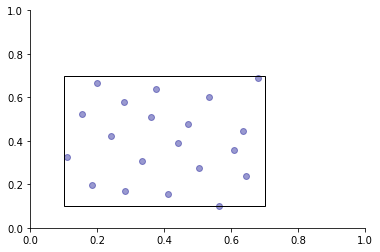

In [5]:
plot_sample(first_points, frames=first_bounds)

For comparison, let us also plot a random design. We can see that there are large areas where no points fall into, and many clustered areas. To avoid sampling those designs we use optimal designs in our optimizers.  

In [6]:
uniform_sample = np.random.uniform(*first_bounds, size=(n_points, dim))

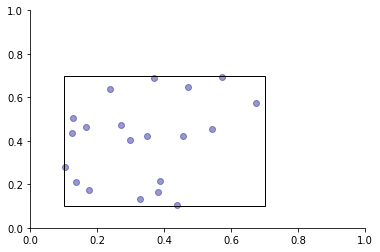

In [7]:
plot_sample(uniform_sample, frames=first_bounds)

In the optimization use-case, the optimizer would perform its magic on the given first sample. If convergence is not achieved the algorithm will propose an update step. This will result in a shift of the lower and upper bounds. The bounds are adjusted so that either we move in some direction, zoom out, zoom in, or some mix of these. Say we move the region to the top-right corner. Then the second cube potentially overlaps with the first cube. This means that there are certain points for which the criterion function was already evaluated. These points can be reused! In the next plot we highlight the points of the first sample that fall into the second cube.

In [8]:
second_bounds = Bounds(lo=0.3 * np.ones(dim), up=0.9 * np.ones(dim))

existing = []
for row in first_points:
    if (second_bounds.lo <= row).all() and (second_bounds.up >= row).all():
        existing.append(row)

existing_xs = np.array(existing)

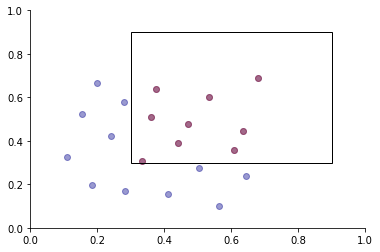

In [9]:
plot_sample(first_points, existing_xs, frames=second_bounds)

Now we only need to reuse these points by creating a valid Latin Hypercube with them. The last plot shows the two samples including the overlapping points.

In [10]:
second_sample = lhs_sampler(
    second_bounds.lo,
    second_bounds.up,
    target_size=n_points,
    existing_xs=existing_xs,
    criterion="maximin",
    n_iter=10_000,
)

second_points = second_sample["points"]

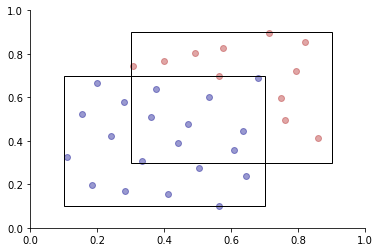

In [12]:
plot_sample(
    first_points,
    second_points,
    frames=[first_bounds, second_bounds],
)

Done! Now the algorithm can use the second sample, however, we were able to safe runtime by not evaluating the points that already fell in the region of the second cube.